In [1]:
%pylab inline
%run params.py

import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from plotting_functions import *

Populating the interactive namespace from numpy and matplotlib


# 2A: simulations per locus

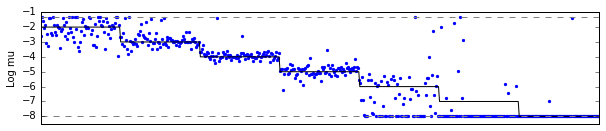

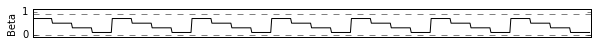

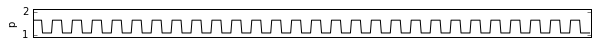

In [27]:
ml = LoadML(os.path.join(DATAPATH, "simulations", "tree_maxlik.tab"), 
            os.path.join(DATAPATH, "simulations", "tree_truth.bed"), 
            os.path.join(DATAPATH, "simulations", "tree_strsd.bed"))

paramcolor = "black"
ml = ml.sort(columns=["mu","beta","strsd"], ascending=False)
order = range(ml.shape[0])
fig = plt.figure()
fig.set_size_inches((10,2))
# mu
ax = fig.add_subplot(1, 1, 1)
ax.plot(order, np.log10(ml.mu), color=paramcolor, linewidth=1)
ax.scatter(order, ml["log_estmu"], color="blue", s=5)
ax.axhline(-8, linestyle="dashed", color="gray")
ax.axhline(np.log10(0.05), linestyle="dashed", color="gray")
ax.set_ylabel("Log mu")
ax.set_xticks([])
ax.set_xlim(left=0, right=len(order))
ax.set_ylim(bottom=-8.5, top=-1.5)
ax.set_yticks(range(-8,0))
fig.savefig(os.path.join(PLOTDIR, "Figure2_simulations_perlocus_mu.pdf"))

# beta
fig = plt.figure()
fig.set_size_inches((10,0.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(order, ml.beta, color=paramcolor, linewidth=1)
ax.axhline(0, linestyle="dashed", color="gray")
ax.axhline(0.9, linestyle="dashed", color="gray")
ax.set_ylabel("Beta")
ax.set_xticks([])
ax.set_xlim(left=0, right=len(order))
ax.set_ylim(bottom=-0.1, top=1.1)
ax.set_yticks([0,1])
fig.savefig(os.path.join(PLOTDIR, "Figure2_simulations_perlocus_beta.pdf"))

# strsd
fig = plt.figure()
fig.set_size_inches((10,0.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(order, ml.strsd, color=paramcolor, linewidth=1)
ax.axhline(0, linestyle="dashed", color="gray")
ax.axhline(0.9, linestyle="dashed", color="gray")
ax.set_ylabel("p")
ax.set_xticks([])
ax.set_xlim(left=0, right=len(order))
ax.set_ylim(bottom=0.9, top=2.1)
ax.set_yticks([1,2]);
fig.savefig(os.path.join(PLOTDIR, "Figure2_simulations_perlocus_strsd.pdf"))

# 2A: joint simulations

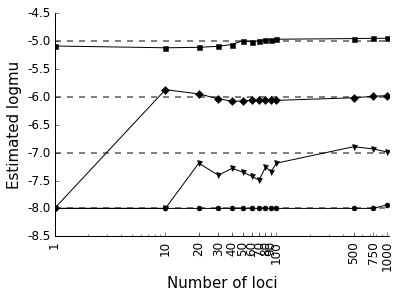

In [31]:
joint = pd.read_csv(os.path.join(DATAPATH,"simulations", "joint_estimates.tab"), sep=" ",
                    names=["logmu","beta","strsd","n","logmu_est","logmu_est_stderr","nn"])

# For each true mu, plot est vs. n
fig = plt.figure()
fig.set_size_inches((6,4))
ax = fig.add_subplot(111)
markers = ["o","v","D","s"]
cind = 0
for tm in set(joint.logmu):
    ax.axhline(tm, linestyle="dashed", color="gray", linewidth=2)
    vals = joint[joint.logmu == tm]
    vals = vals.sort("n")
    ax.semilogx(vals.n, vals.logmu_est, color="black", linewidth=1, marker=markers[cind], markersize=5)
    cind += 1
ax.set_ylim(bottom=-8.5, top=-4.5)
ax.set_xlim(left=9, right=1050)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(list(set(joint.n)))
ax.set_xticklabels(map(int, ax.get_xticks()), size=12, rotation=90)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_xlabel("Number of loci", size=15)
ax.set_ylabel("Estimated logmu", size=15)
fig.savefig(os.path.join(PLOTDIR, "Figure2_simulations_joint.pdf"))

# 2C: Y-strs

In [33]:
# Load YSTR data
ysgdp = LoadMLData(os.path.join(DATAPATH, "ystr_validation", "ystrs_sgdp_ml.tab"))
ysgdp["strsd2"] = ysgdp.apply(lambda x: (2-x.est_pgeom_ml)/x.est_pgeom_ml**2, 1)
ysgdp["est_beta_ml_eff"] = ysgdp.apply(lambda x: x.est_beta_ml/x.strsd2, 1)
y1kg = LoadMLData(os.path.join(DATAPATH, "ystr_validation", "ystrs_1kg_ml.tab"))
y1kg["chrom"] = "Y"
y1kg["strsd2"] = y1kg.apply(lambda x: (2-x.est_pgeom_ml)/x.est_pgeom_ml**2, 1)
y1kg["est_beta_ml_eff"] = y1kg.apply(lambda x: x.est_beta_ml/x.strsd2, 1)
truth = pd.read_csv(os.path.join("../analyses/ystr_validation/ystrs_literature_mutrates.tab"), sep="\t")

# Merge
data = pd.merge(ysgdp, truth, on=["chrom","start","end"], how="outer")
data = pd.merge(data, y1kg, on=["chrom","start","end"])
data["sgdp_strsd2"] = data.apply(lambda x: (2-x.sgdp_pgeom)/x.sgdp_pgeom**2, 1)
data["sgdp_beta_eff"] = data.apply(lambda x: x.sgdp_beta/x.sgdp_strsd2, 1)

# Scale to have same mean
kgscale = np.mean(10**(data["est_logmu_ml_x"]))/np.mean(10**(data["est_logmu_ml_y"]))
muteascale = np.mean(10**(data["est_logmu_ml_x"]))/np.mean(10**(data["log10_sgdp_mu"]))
bscale = np.mean(10**(data["est_logmu_ml_x"]))/np.mean(10**(data["ballantyne_logmu"]))
data["est_logmu_ml_y"] = data["est_logmu_ml_y"] + np.log10(kgscale)
data["log10_sgdp_mu"] = data["log10_sgdp_mu"] + np.log10(muteascale)
data["ballantyne_logmu"] = data["ballantyne_logmu"] + np.log10(bscale)
print "scales", kgscale, muteascale, bscale

scales 0.648500299811 0.52289566619 0.407393637127


mu: est_logmu_ml_x vs. log10_sgdp_mu (0.89111973571471736, 5.854787211208951e-15) 41


(<matplotlib.figure.Figure at 0x10b32fe90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10c562d10>)

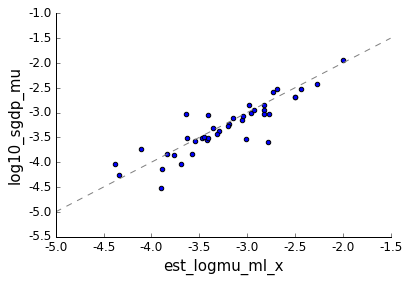

In [35]:
CompareMu(data, "est_logmu_ml_x","log10_sgdp_mu", figname=os.path.join(PLOTDIR, "Figure2_ystrs.pdf"))

# 2D: Marshfield

[-4.0703775783631109, -3.4273794930367947] -3.8904776276 -3.50492226484 1445 189


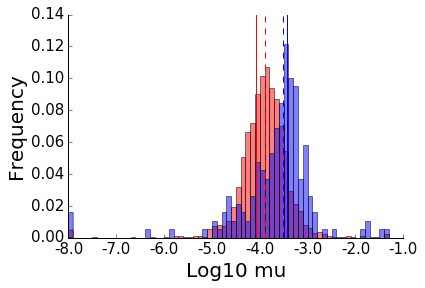

In [3]:
# Load Marshfield data
meta = pd.read_csv(os.path.join("../analyses/autosomal_validation", "sun_etal_msat_data_hg19_lobSTRcoords.bed"), sep="\t",
                   names=["chrom","start","end","motif","sunlength","denom","num"], usecols=range(4)+[4,5,6])
meta["period"] = meta["motif"].apply(len)
meta = meta[meta["denom"]>0]

data = LoadMLData(os.path.join(DATAPATH, "autosomal_validation", "sunetal_estimates_ml.bed"))
data = pd.merge(data, meta, on=["chrom","start","end"])

scalefactor = 0.417
truth = []
for period in [2, 4]:
    x = data[data["period"]==period]
    truth.append(np.log10(np.sum(x.num)*1.0/np.sum(x.denom))+np.log10(scalefactor))
    
def PlotMuByPeriod(data, mucol, figname=None, eff=False, truth=None):
    dimu = np.array(data[(data["period"]==2)&~np.isnan(data[mucol])][mucol].values) 
    tetramu = np.array(data[(data["period"]==4)&~np.isnan(data[mucol])][mucol].values)
    if eff:
        dimu = [np.log10(10**item/2.6) for item in dimu]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    bins = np.arange(-8,-1,0.1)
    ax.hist(dimu, color="red", alpha=0.5, bins=bins, weights = np.ones_like(dimu)/len(dimu))
    ax.hist(tetramu, color="blue", alpha=0.5, bins=bins, weights = np.ones_like(tetramu)/len(tetramu))
    if truth is None: truth = [np.log10(2.73*10**-4), np.log10(10.01*10**-4)] # Sun eta l.
    print truth, np.median(dimu), np.median(tetramu), len(dimu), len(tetramu)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left();
    ax.set_yticklabels(map(lambda x: "%0.2f"%x, ax.get_yticks()), size=15)
    ax.set_xticklabels(ax.get_xticks(), size=15)
    ax.set_xlabel("Log10 mu", size=20)
    ax.set_ylabel("Frequency", size=20)
    ax.axvline(truth[0], color="red")
    ax.axvline(truth[1], color="blue")
    ax.axvline(np.median(dimu), color="red", linestyle="dashed")
    ax.axvline(np.median(tetramu), color="blue", linestyle="dashed")
    if figname is not None: fig.savefig(figname)

PlotMuByPeriod(data, "est_logmu_ml", figname=os.path.join(PLOTDIR, "Figure2_marsh.pdf"), truth=truth)